In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
from statsmodels.tsa.stattools import adfuller # type: ignore
from statsmodels.tsa.arima.model import ARIMA # type: ignore
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error # type: ignore
import warnings
warnings.filterwarnings("ignore")

# Time Series Analysis: Comparing LSTM and ARIMA Models

This notebook demonstrates a comprehensive approach to time series forecasting using two popular models: Long Short-Term Memory (LSTM) networks and AutoRegressive Integrated Moving Average (ARIMA). The primary focus is on predicting appliance energy usage from time-stamped data recorded every 10 minutes.

### Key Steps and Techniques:

1. **Exploratory Data Analysis**:
   - The initial phase involves understanding the dataset's structure, identifying missing values, and highlighting the significance of appliance energy usage in energy management and cost savings.
   
2. **Data Preparation**:
   - Feature normalization using MinMaxScaler to prepare the data for LSTM training.
   
3. **LSTM Model**:
   - **Data Structure**: Time series data is reshaped to create a sequence suitable for LSTM, including data preparation for both inputs and forecast sequences.
   - **Model Training**: A Sequential LSTM model is designed and trained with 50 epochs using 'Adam' optimizer.
   - **Evaluation**: The model's performance is assessed using MSE, MAE, and R-squared metrics, and predictions are plotted against actual values.
   
4. **ARIMA Model**:
   - **Data Stationarity**: The stationarity of the data is verified using the ADFuller test to ensure it is suitable for ARIMA modeling.
   - **Model Fitting**: An ARIMA model is fitted, and its residuals are analyzed.
   - **Prediction and Evaluation**: The ARIMA model's forecasts are compared with the actual data, and performance metrics are calculated.
   
5. **Model Comparison**:
   - Both models are evaluated and compared to determine their efficacy in handling time series data in different scenarios.

Each section of the notebook includes detailed steps for data manipulation, model building, and evaluation, making it a valuable resource for anyone looking to understand or apply time series in their projects.


# 1. Exploratory Data Analysis and Visualization

## 1.1 Load the dataset

In [2]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.describe(),data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

(                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
 0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
 1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
 2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
 3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
 4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   
 
       T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
 0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
 1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
 2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
 3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
 4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   
 
    RH_out  Windsp

## 1.2 Checking for missing values

In [3]:
data.isnull().sum().sum()

0

The dataset has 19,735 entries and 29 columns and fortunately there is no missing value in the dataset.

## 1.3 Why Focus on Appliance Energy Use?

**Relevance to Energy Management:** Appliance energy consumption constitutes a significant portion of total household energy usage. Gaining insights into its behavior enables more effective energy management and enhances overall efficiency.

**Potential for Cost Savings:** Analyzing patterns in appliance usage facilitates the optimization of their operation, resulting in cost savings. By identifying efficient usage patterns, households can minimize energy waste and reduce expenses.


In [4]:
# Convert 'date' column to datetime type and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


selected_columns = ['Appliances']
data_selected = data[selected_columns]

data_selected.head()


,Appliances
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


## Plotting the appliance energy usage over time

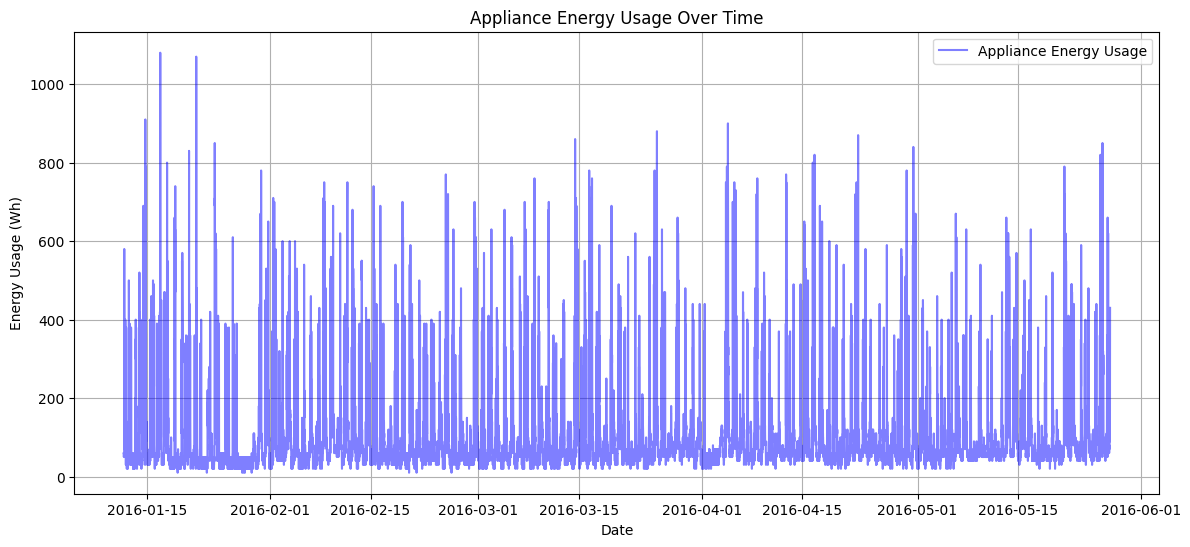

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(data_selected['Appliances'], label='Appliance Energy Usage', color='blue', alpha=0.5)
plt.title('Appliance Energy Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Usage (Wh)')
plt.legend()
plt.grid(True)
plt.show()

From the plot above, we can observe several key aspects regarding the appliance energy usage:

- **Variability:** The energy usage of appliances varies significantly over time. There are noticeable spikes in usage, which could correspond to specific times of day or to the usage of high-energy-consuming appliances.

- **Trend:** There doesn't seem to be a clear long-term upward or downward trend over the months covered by the data. The usage is quite cyclical with high variability, suggesting that it might be influenced by daily activities or external factors such as weather.

- **Potential Patterns:** The recurring spikes suggest that there might be specific times during the day when energy usage peaks. To analyze this further, we can look at daily or weekly averages and observe if there are consistent patterns during certain hours or days.


## Plotting the daily average appliance energy usage

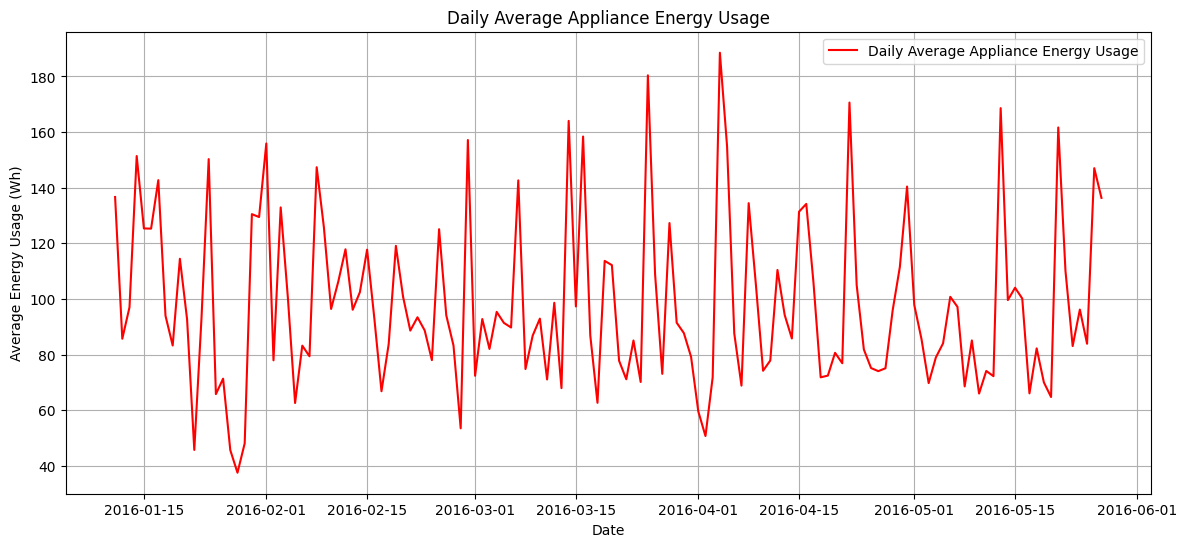

In [6]:
# Resampling data to daily means
daily_data = data_selected['Appliances'].resample('D').mean()

plt.figure(figsize=(14, 6))
plt.plot(daily_data, label='Daily Average Appliance Energy Usage', color='red')
plt.title('Daily Average Appliance Energy Usage')
plt.xlabel('Date')
plt.ylabel('Average Energy Usage (Wh)')
plt.legend()
plt.grid(True)
plt.show()


The plot of daily average appliance energy usage reveals a clearer pattern of how consumption fluctuates over time. Although the data still shows variability, the extreme peaks are smoothed out, providing a better visualization of overall trends.

## Plotting the average appliance energy usage by day of the week

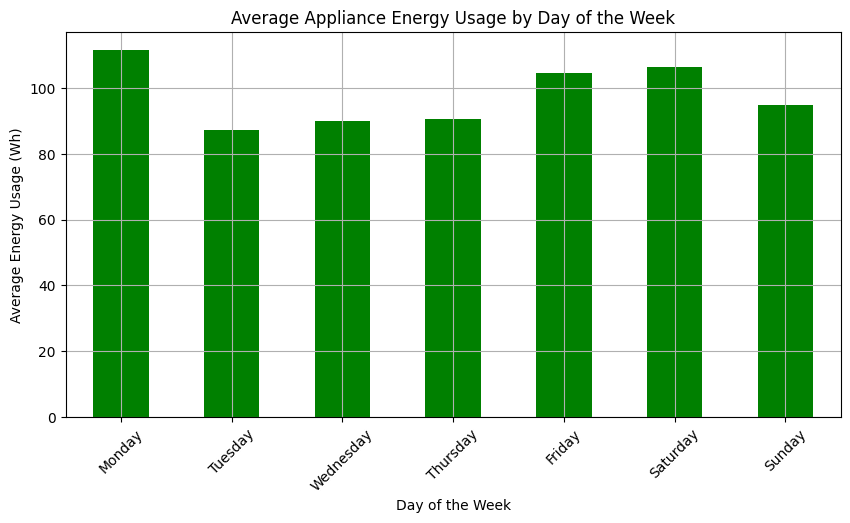

In [7]:
# Adding a 'day_of_week' column to the original dataset
data['day_of_week'] = data.index.day_name()

# Grouping data by the day of the week and calculating mean appliance energy usage
weekly_pattern = data.groupby('day_of_week')['Appliances'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 5))
weekly_pattern.plot(kind='bar', color='green')
plt.title('Average Appliance Energy Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Usage (Wh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


- **Weekend vs. Weekday Usage**: There appears to be a slight increase in energy usage on weekends, particularly on Sundays. This could be due to more activities at home, such as cooking, laundry, or other household chores that typically increase on weekends.
- **Consistent Usage During Weekdays**: The energy usage from Monday to Friday is relatively consistent, with only minor fluctuations. This suggests a stable pattern likely tied to regular daily routines.

# 2. All About LSTM
### Why LSTM for Appliance Energy Prediction?

LSTM is adept at capturing patterns in time series data, making it ideal for predicting appliance energy usage over time. Its ability to remember past usage patterns enables accurate predictions, which is crucial for tasks where historical context influences future outcomes.

## 2.1 Normalize the features

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_selected)

# Convert to DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=selected_columns)

# Display the first few rows of the scaled data
data_scaled_df.head()

,Appliances
0,0.046729
1,0.046729
2,0.037383
3,0.037383
4,0.046729


## 2.2 Data Preparation for LSTM

Since our dataset consists of time series data recorded every 10 minutes, we will provide one hour of data at each timestamp.


In [9]:
def lstm_data_preparation(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = [f'var(t-{i})' for i in range(n_in, 0, -1)] + [f'var(t+{i})' for i in range(n_out)]
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define time steps
n_steps = 6
prepared_data = lstm_data_preparation(data_scaled_df, n_steps, 1)
prepared_data.head()

,var(t-6),var(t-5),var(t-4),var(t-3),var(t-2),var(t-1),var(t+0)
6,0.046729,0.046729,0.037383,0.037383,0.046729,0.037383,0.046729
7,0.046729,0.037383,0.037383,0.046729,0.037383,0.046729,0.046729
8,0.037383,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729
9,0.037383,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075
10,0.046729,0.037383,0.046729,0.046729,0.046729,0.056075,0.205607


## 2.3 Split into train and test sets

In [10]:
n_train_steps = int(prepared_data.shape[0] * 0.8)
train = prepared_data.values[:n_train_steps, :]
test = prepared_data.values[n_train_steps:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X.shape,test_X.shape,train_y.shape,test_y.shape

((15783, 6), (3946, 6), (15783,), (3946,))

## 2.4 Reshape input to be 3D [samples, timesteps, features]

In [11]:
train_X = train_X.reshape((train_X.shape[0], n_steps, 1))
test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

## 2.5 Design the LSTM model

In [12]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')


## 2.6 Training the model with 50 epochs and plotting the training and validation losses

Epoch 1/50
124/124 - 7s - loss: 0.0378 - val_loss: 0.0273 - 7s/epoch - 58ms/step
Epoch 2/50
124/124 - 2s - loss: 0.0324 - val_loss: 0.0254 - 2s/epoch - 18ms/step
Epoch 3/50
124/124 - 1s - loss: 0.0300 - val_loss: 0.0243 - 1s/epoch - 10ms/step
Epoch 4/50
124/124 - 1s - loss: 0.0280 - val_loss: 0.0233 - 1s/epoch - 11ms/step
Epoch 5/50
124/124 - 2s - loss: 0.0268 - val_loss: 0.0232 - 2s/epoch - 14ms/step
Epoch 6/50
124/124 - 2s - loss: 0.0266 - val_loss: 0.0232 - 2s/epoch - 15ms/step
Epoch 7/50
124/124 - 1s - loss: 0.0265 - val_loss: 0.0231 - 1s/epoch - 10ms/step
Epoch 8/50
124/124 - 1s - loss: 0.0265 - val_loss: 0.0231 - 1s/epoch - 10ms/step
Epoch 9/50
124/124 - 2s - loss: 0.0264 - val_loss: 0.0230 - 2s/epoch - 14ms/step
Epoch 10/50
124/124 - 1s - loss: 0.0264 - val_loss: 0.0230 - 1s/epoch - 11ms/step
Epoch 11/50
124/124 - 1s - loss: 0.0263 - val_loss: 0.0230 - 1s/epoch - 10ms/step
Epoch 12/50
124/124 - 1s - loss: 0.0263 - val_loss: 0.0230 - 1s/epoch - 12ms/step
Epoch 13/50
124/124 - 1s 

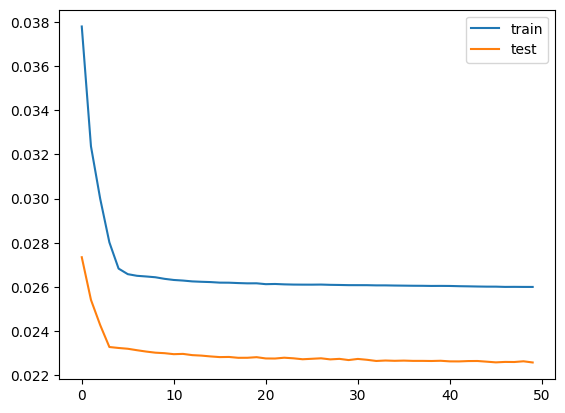

In [13]:
history = lstm_model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2.7 Make predictions on test data and plotting actual test and vs predited data

124/124 [==============================] - 1s 3ms/step


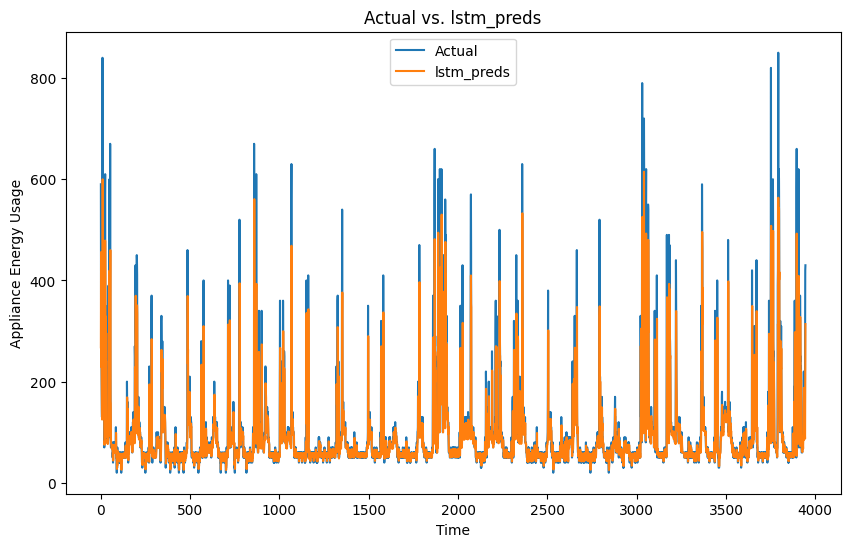

In [14]:
lstm_preds = lstm_model.predict(test_X)

# Inverse scaling for a plot
actual = scaler.inverse_transform(test_y.reshape(-1, 1))
lstm_preds = scaler.inverse_transform(lstm_preds)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(lstm_preds, label='lstm_preds')
plt.title('Actual vs. lstm_preds')
plt.xlabel('Time')
plt.ylabel('Appliance Energy Usage')
plt.legend()
plt.show()


## 2.8 LSTM Evaluation on test data

In [15]:
lst_mse = mean_squared_error(actual, lstm_preds)
lst_mae = mean_absolute_error(actual, lstm_preds)
lst_r_squared = r2_score(actual, lstm_preds)
print("Mean Squared Error (MSE) LSTM:", lst_mse)
print("Mean Absolute Error (MSE) for LSTM:", lst_mae)
print("R Score for LSTM:", lst_r_squared)


Mean Squared Error (MSE) LSTM: 3623.9288850056446
Mean Absolute Error (MSE) for LSTM: 24.15938696206311
R Score for LSTM: 0.561858383015083


# 3 All About ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a widely-used model for time series analysis, including appliance energy prediction.

### Why ARIMA for Appliance Energy Prediction?

ARIMA is adept at capturing patterns in time series data and is well-suited for tasks like appliance energy prediction, where historical patterns influence future outcomes. It models relationships between current and past observations, accounts for data stationarity, and helps stabilize fluctuations in the data for accurate predictions.

## 3.1 Data Preparation for ARIMA

We cannot feed the prepared data for LSTM to the ARIMA model because ARIMA expects different input data. Therefore, we will use different approaches for data preparation. Additionally, we can feed the data without scaling it. We will select 80% of the data for training and 20% for testing to evaluate and compare the models.


In [16]:
train = data_selected.iloc[:np.int64(len(data_selected)*0.8)]
test = data_selected.iloc[np.int64(len(data_selected)*0.8):]
train.shape, test.shape

((15788, 1), (3947, 1))

## 3.2 Checking for data stationaity usiing ADFULER Test

In [17]:
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.0


Our dataset is stationary, because we have very small p-value, so we can proceed

## 3.3 ACF plot and PACF plot

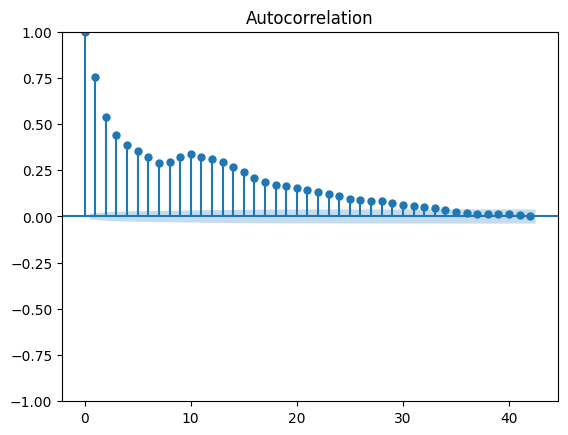

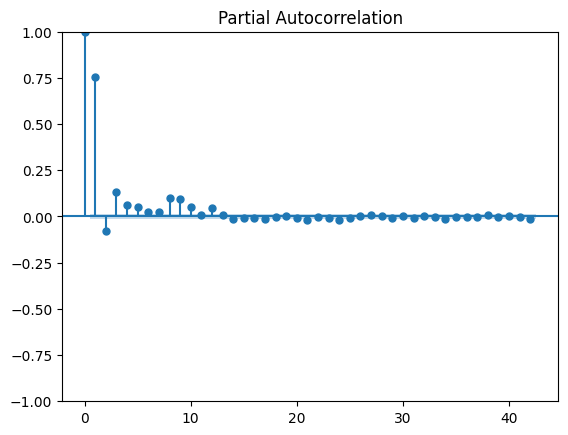

In [18]:
acf_original = plot_acf(train)

pacf_original = plot_pacf(train)

## 3.4 Determine ARIMA Model Parameters (p, q)

Selecting the right ARIMA model parameters (p, q) is crucial because they directly impact the model's ability to capture the underlying patterns in the data. By choosing appropriate values for p and q, we ensure that the ARIMA model accurately reflects the autocorrelation and moving average components present in the time series data. This helps in making reliable predictions and improving the overall performance of the model.

## 3.5 Fit the ARIMA model

In [19]:
arima_model = ARIMA(train, order=(2,0,2))
trained_arima_model = arima_model.fit()
print(trained_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Appliances   No. Observations:                15788
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -88858.209
Date:                Mon, 29 Apr 2024   AIC                         177728.418
Time:                        23:53:39   BIC                         177774.420
Sample:                    01-11-2016   HQIC                        177743.643
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.0251      7.257     13.508      0.000      83.802     112.248
ar.L1          1.3625      0.015     92.467      0.000       1.334       1.391
ar.L2         -0.3895      0.013    -30.516      0.0

## 3.6 Plotting residuls and Density

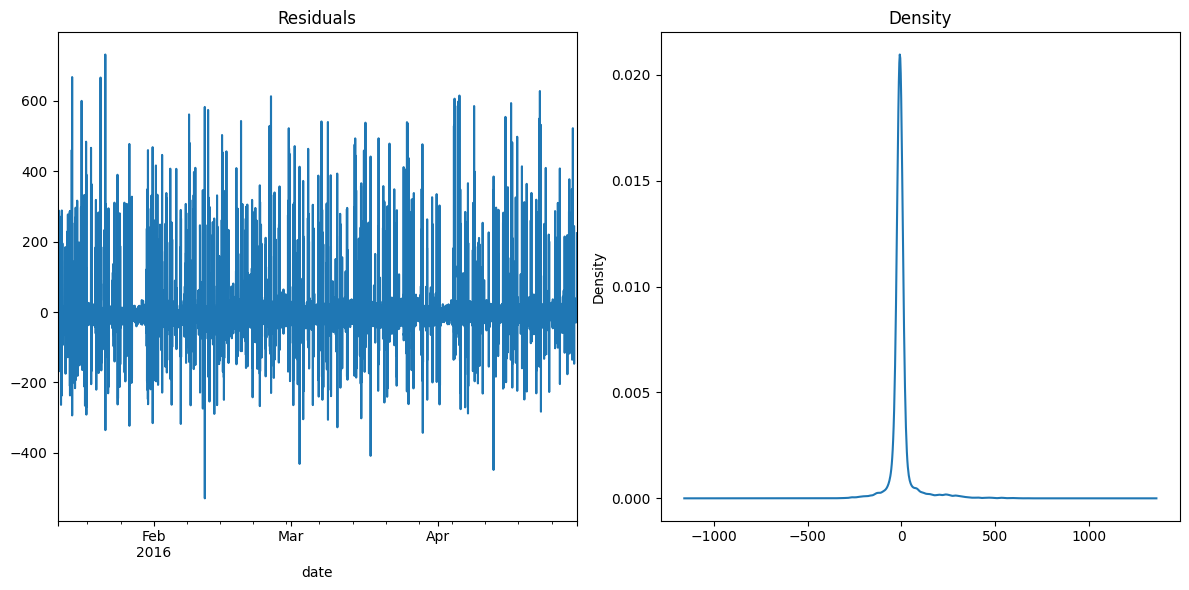

In [20]:
plt.figure(figsize=(12, 6))
residuals = trained_arima_model.resid[1:]
plt.subplot(1, 2, 1)
residuals.plot(title='Residuals')
plt.subplot(1, 2, 2)
residuals.plot(title='Density', kind='kde')
plt.tight_layout()
plt.show()

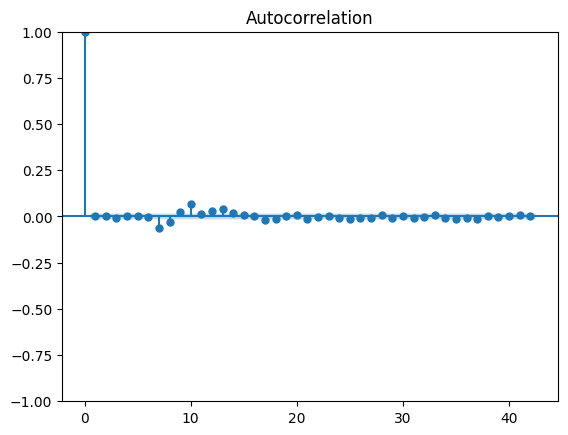

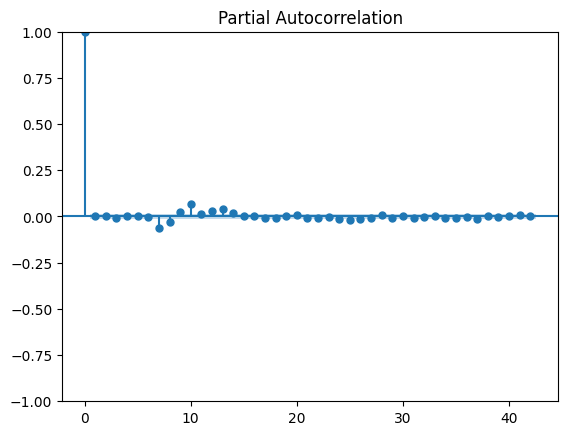

In [21]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

## 3.7 Making predictions on test data and plotting

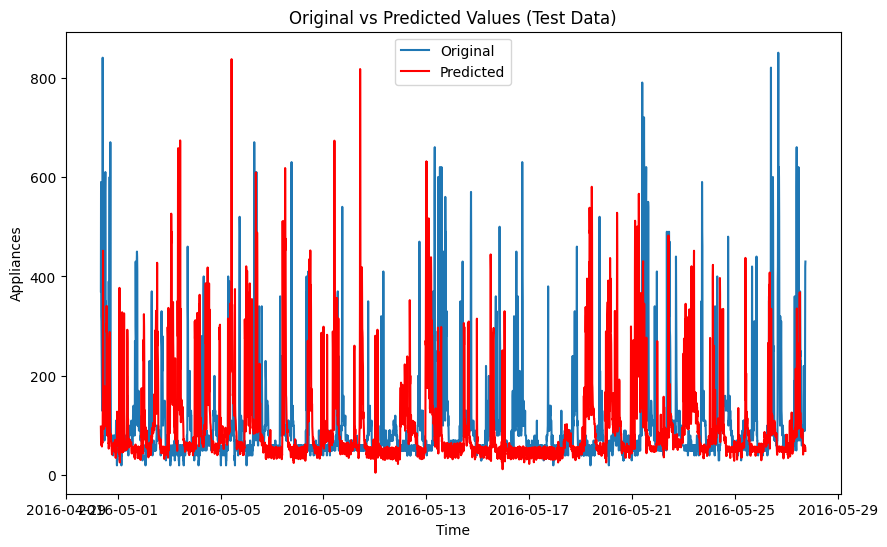

In [22]:
arima_preds = trained_arima_model.predict(start=0, end=len(test)-1, typ='levels')

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Appliances'], label='Original')
plt.plot(test.index, arima_preds, color='red', label='Predicted')
plt.title('Original vs Predicted Values (Test Data)')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.show()


## 3.8 ARIMA Model Evaluation

##

In [23]:
arima_mse = mean_squared_error(test['Appliances'], arima_preds)
arima_mae = mean_absolute_error(test['Appliances'], arima_preds)
arima_r_squared = r2_score(test['Appliances'], arima_preds)

print("Mean Squared Error (MSE) for ARIMA:", arima_mse)
print("Mean Absolute Error (MSE) for ARIMA:", arima_mae)
print("R Score for ARIMA:", arima_r_squared)



Mean Squared Error (MSE) for ARIMA: 16711.18003618917
Mean Absolute Error (MSE) for ARIMA: 75.0536956341474
R Score for ARIMA: -1.0163069406093985


# 4. Model Comparison

In [24]:
comparison_data = {
    'Model': ['LSTM', 'ARIMA'],
    'Mean Squared Error': [lst_mse, arima_mse],
    'Mean Absolute Error': [lst_mae, arima_mae],
    'R-squared': [lst_r_squared, arima_r_squared]
}

comparison_table = pd.DataFrame(comparison_data)

print(comparison_table)

   Model  Mean Squared Error  Mean Absolute Error  R-squared
0   LSTM         3623.928885            24.159387   0.561858
1  ARIMA        16711.180036            75.053696  -1.016307


The table compares the performance metrics of both models. The LSTM model exhibits significantly lower Mean Squared Error (MSE) and Mean Absolute Error (MAE) values compared to the ARIMA model, indicating its superior accuracy in predicting appliance consumption levels. Moreover, the LSTM model achieves a positive R-squared value, suggesting that it explains a considerable portion of the variance in the data, whereas the ARIMA model yields a negative R-squared value, indicating poor performance and a fit worse than a horizontal line. Overall, these results underscore the superior predictive capability of the LSTM model over the ARIMA model for this particular forecasting task.
